# Topic Modeling with Coherence Plot
Update: 20.04.2021<br>
Mai Vu

In [3]:
#Basic libraries
import random
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from collections import defaultdict

import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)

#Libraries for lemmatization
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#Lirary to check the language in text
from langdetect import detect

#Libraries for topic modeling
import gensim
from gensim import corpora
import pprint
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel

#For plotting
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# Init steps

In [4]:
#Read the data
eng_data = pd.read_csv('eng_abstracts.csv')

In [5]:
#Create eng_stopwords set and lemmatizer from NLTK library
eng_stopwords = set(stopwords.words('english')).union(gensim.parsing.preprocessing.STOPWORDS)
eng_stopwords.update({'thesis', 'study', 'research', 'group', 'part', 'work', 'use', 'new', 'based', 'using', 'people'}) #Delete common words
lemmatizer = WordNetLemmatizer()

In [6]:
def CalculateCoherenceRange(texts, corpus, dictionary, start = 1, end = 20):
    """Function to calculate the coherence scores of different LDA models with the number of topics in the given range.
    
    Args:
        (list) texts: abstracts in text.
        (list) bow: bag of words of abstracts.
        (Dictionary) dictionary: set of stopwords from NLTK library.
        (integers) start, end: number of topics' range.

    Returns:
        (list): coherence scores of different LDA models with the number of topics in the given range.
    """
    coherence = []
    for num_topic in range(start, end + 1):
        LDA_model = LdaModel(corpus, num_topics = num_topic, id2word = dictionary, passes = 10)
        cohm = CoherenceModel(model = LDA_model, texts = texts, corpus = corpus, dictionary = dictionary, coherence = 'c_v')
        coherence.append(cohm.get_coherence())
    return coherence

In [7]:
def PlotKeywords(LDA_model, num_topic, num_word = 8):
    """Function to plot important keywords .
    Abstracts are divided into smaller subsets so that the coherence curve will be smoother.
    
    Args:
        (LdaModel) LDA_model: abstracts in text.
        (integer) num_topic: number of topics of the model.
        (integer) num_word: number of words to plot.

    Returns:
        None.
    """
    keywords = [[word for word, _ in LDA_model.show_topic(topicid, topn = 20)] for topicid in range(LDA_model.num_topics)]
    keywords_prob = [[beta for _, beta in LDA_model.show_topic(topicid, topn = 20)] for topicid in range(LDA_model.num_topics)]

    gs = gridspec.GridSpec(round(math.sqrt(num_topic)) + 1, round(math.sqrt(num_topic)) + 1)
    gs.update(wspace = 0.5, hspace = 0.5)
    plt.figure(figsize = (20, 15))
    for i in range(num_topic):
        ax = plt.subplot(gs[i])
        plt.barh(range(num_word), keywords_prob[i][:num_word])
        ax.invert_yaxis()
        ax.set_yticks(range(num_word))
        ax.set_yticklabels(keywords[i][:num_word])
        plt.grid()
        plt.title("Topic " + str(i + 1))

# 1. All words corpus

In [8]:
start_time = time.time() #Start count time

#Tokenization and delete punctuation, number, short words and stop words
allwords_pre_abstracts = []
count = defaultdict(int)
for abstract in eng_data['abstract_en']:
    tokens = []
    for token in nltk.word_tokenize(abstract.lower()):
        if token.isalpha() and token not in eng_stopwords and len(token) > 3:
            tokens.append(lemmatizer.lemmatize(token))
            count[token] += 1 #Count word frequencies
    allwords_pre_abstracts.append(tokens)

#Delete words that appear very few times
allwords_abstracts = [[token for token in abstract if count[token] > 10] for abstract in allwords_pre_abstracts]

print('- Finish preprocessing data (all words) in', round((time.time() - start_time)/60), 'min(s)')

- Finish preprocessing data (all words) in 1 min(s)


In [9]:
#Create dictionary for the given texts
allwords_dictionary = corpora.Dictionary(allwords_abstracts)
print(allwords_dictionary)

#Create the bag of words for all documents
allwords_bow = [allwords_dictionary.doc2bow(abstract) for abstract in allwords_abstracts]

Dictionary(6431 unique tokens: ['activity', 'actual', 'analyse', 'area', 'book']...)


## 1.1 Choose the number of topics

- Finish in 40 min(s)


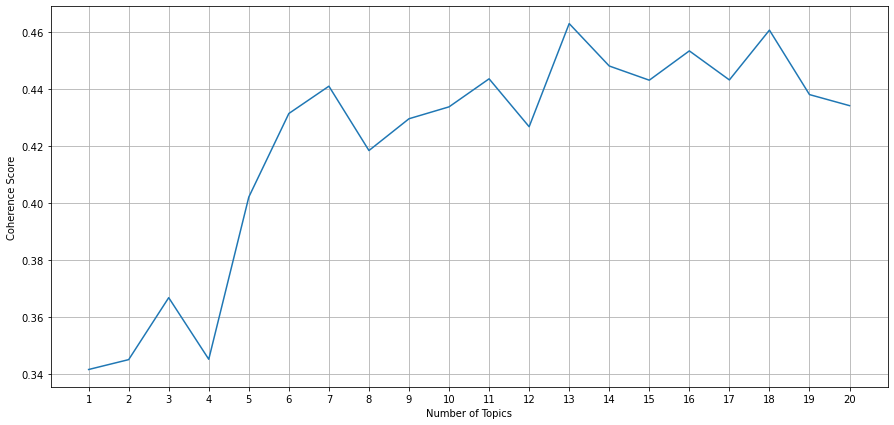

In [10]:
start_time = time.time() #Start count time
allwords_coherence = CalculateCoherenceRange(allwords_abstracts, allwords_bow, allwords_dictionary)
print('- Finish in', round((time.time() - start_time)/60), 'min(s)')

#Plot the coherence plot
plt.figure(figsize = (15, 7))
plt.plot(range(1, 21), allwords_coherence)
plt.xticks(range(1, 21))
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.grid()

## 1.2 LDA model with 13 topics

In [11]:
allwords_LDA_model = LdaModel(allwords_bow, num_topics = 13, id2word = allwords_dictionary, random_state = 111, passes = 30)

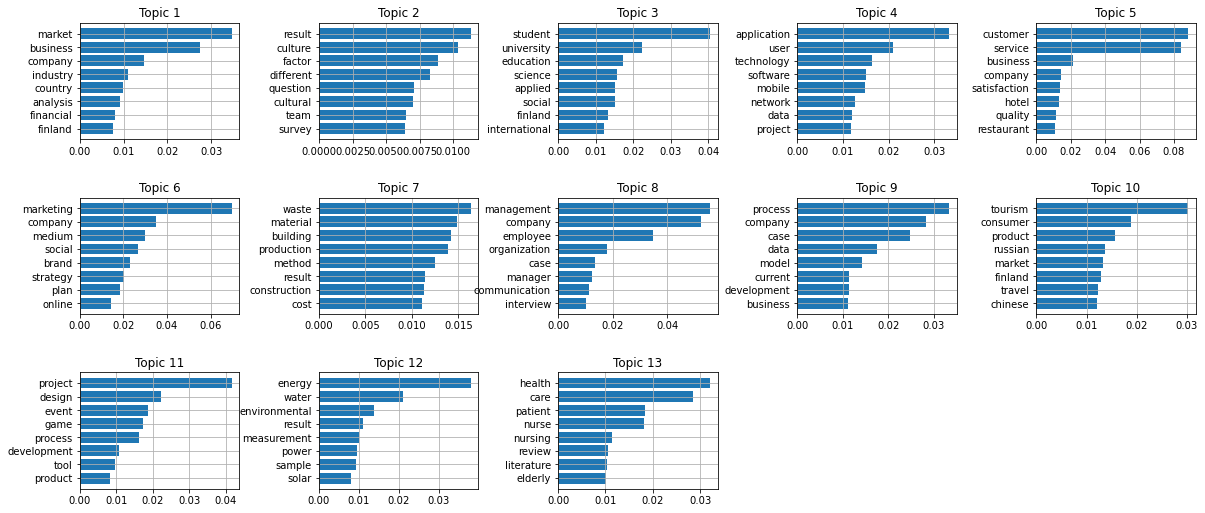

In [12]:
PlotKeywords(allwords_LDA_model, 13)

**GUESSING TOPICS**<br>
Topic 1:  Market/Business<br>
Topic 2:  Culture<br>
Topic 3:  Education<br>
Topic 4:  Information Technology<br>
Topic 5:  Customer Service<br>
Topic 6:  Marketing<br>
Topic 7:  Material<br>
Topic 8:  Company Management<br>
Topic 9:  Company Case<br>
Topic 10: Tourism<br>
Topic 11: Event<br>
Topic 12: Environmental<br>
Topic 13: Healthcare<br>

## 1.3 Plot topics

In [13]:
allwords_display = gensimvis.prepare(allwords_LDA_model, allwords_bow, allwords_dictionary, sort_topics = False)
pyLDAvis.display(allwords_display)

## 1.4 Evaluate model

In [14]:
allwords_coherence = gensim.models.CoherenceModel(model = allwords_LDA_model, texts = allwords_abstracts, dictionary = allwords_dictionary, coherence = 'c_v')
print('Coherence Score:', round(allwords_coherence.get_coherence(), 3))

Coherence Score: 0.448


# 2. Only noun corpus

In [15]:
start_time = time.time() #Start count time

#Tokenization and delete punctuation, number, short words and stop words
nouns_pre_abstracts = []
count = defaultdict(int)
for abstract in eng_data['abstract_en']:
    noun = []
    for token in nltk.word_tokenize(abstract.lower()):
        if token.isalpha() and token not in eng_stopwords and len(token) > 3:
            for (word, pos) in nltk.pos_tag({lemmatizer.lemmatize(token)}):
                if pos[0] == 'N': #Take only noun
                    noun.append(word)
                    count[word] += 1 #Count word frequencies
    nouns_pre_abstracts.append(noun)

#Delete words that appear very few times
nouns_abstracts = [[token for token in abstract if count[token] > 10] for abstract in nouns_pre_abstracts]

print('- Finish preprocessing data (all words) in', round((time.time() - start_time)/60), 'min(s)')

- Finish preprocessing data (nouns only) in 17 min(s)


In [16]:
#Create dictionary for the given texts
nouns_dictionary = corpora.Dictionary(nouns_abstracts)
print(nouns_dictionary)

#Create the bag of words for all documents
nouns_bow = [nouns_dictionary.doc2bow(abstract) for abstract in nouns_abstracts]

Dictionary(4590 unique tokens: ['activity', 'analyse', 'area', 'book', 'business']...)


## 2.1 Choose the number of topics

- Finish in 33 min(s)


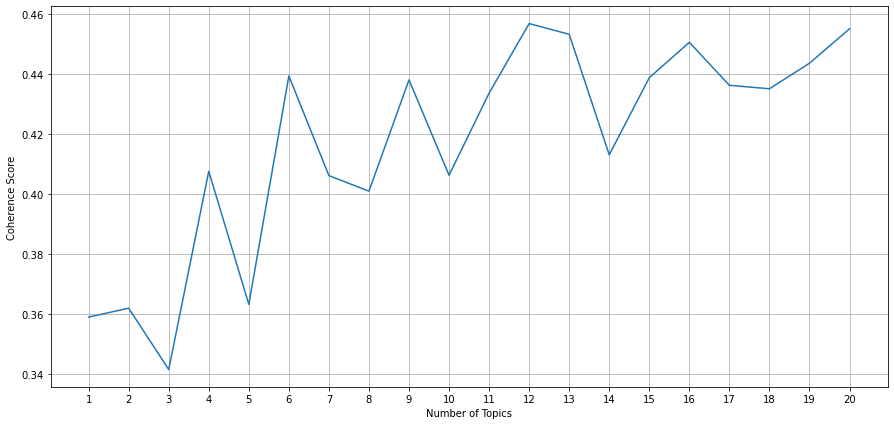

In [17]:
start_time = time.time() #Start count time
nouns_coherence = CalculateCoherenceRange(nouns_abstracts, nouns_bow, nouns_dictionary)
print('- Finish in', round((time.time() - start_time)/60), 'min(s)')

#Plot the coherence plot
plt.figure(figsize = (15, 7))
plt.plot(range(1, 21), nouns_coherence)
plt.xticks(range(1, 21))
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.grid()

## 2.2 LDA model with 12 topics

In [22]:
nouns_LDA_model = LdaModel(nouns_bow, num_topics = 12, id2word = nouns_dictionary, random_state = 111, passes = 50)

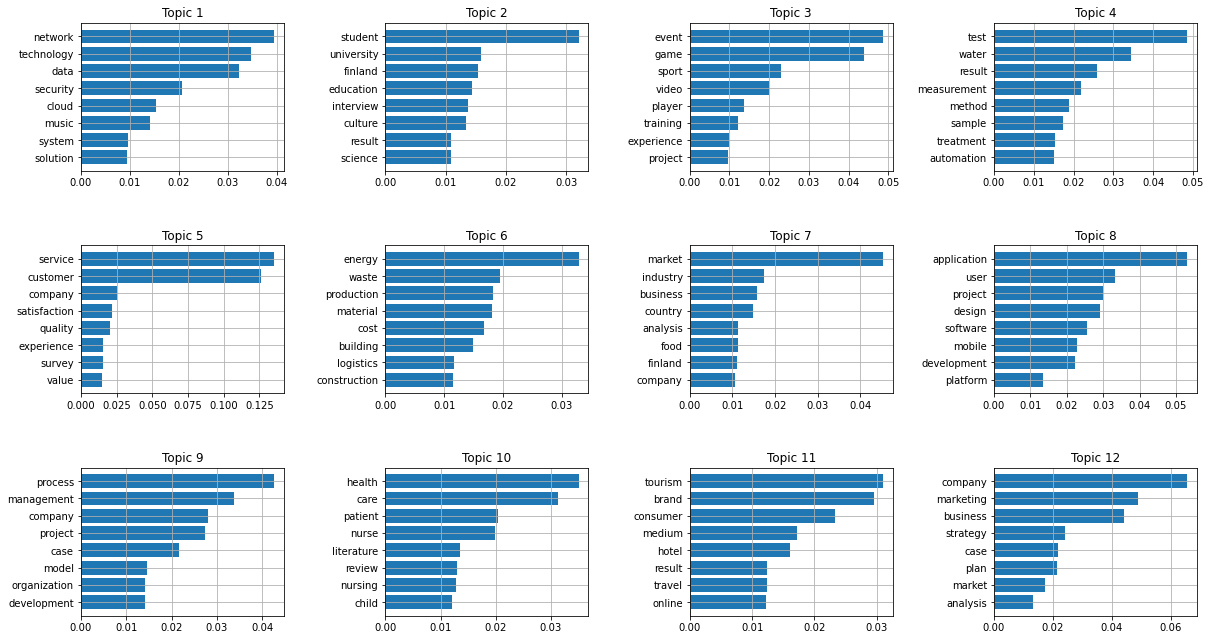

In [23]:
PlotKeywords(nouns_LDA_model, 12)

**GUESSING TOPICS**<br>
Topic 1:  Network<br>
Topic 2:  Education<br>
Topic 3:  Game/Event<br>
Topic 4:  Water test<br>
Topic 5:  Customer Service<br>
Topic 6:  Energy<br>
Topic 7:  Market<br>
Topic 8:  Software<br>
Topic 9:  Company Management<br>
Topic 10: Healthcare<br>
Topic 11: Tourism<br>
Topic 12: Makerting<br>

## 2.3 Plot topics

In [20]:
nouns_display = gensimvis.prepare(nouns_LDA_model, nouns_bow, nouns_dictionary, sort_topics = False)
pyLDAvis.display(nouns_display)

## 2.4 Evaluate model

In [21]:
nouns_coherence = gensim.models.CoherenceModel(model = nouns_LDA_model, texts = nouns_abstracts, dictionary = nouns_dictionary, coherence = 'c_v')
print('Coherence Score:', round(nouns_coherence.get_coherence(), 3))

Coherence Score: 0.447
